# Merian project Part 1

**Explore the morphology of dwarf galaxies in H$\alpha$ using the Merian Survey data**

- [x] Parse the photo-z catalog in COSMOS, and understand how many of them have spec-z
- [ ] Generate cutout, and study how to make a beautiful image
- [x] Study how to use Abby's code
- [ ] Possible Jellyfish project

**Prerequisites**
- Need to install `reproject` and `photutils` and `cmasher`

In [68]:
%load_ext autoreload
%autoreload 2
import os, sys
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
required_packages = ['statmorph', 'sep']  # Define the required packages for this notebook

import sys
import subprocess

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Download utils.py
    !wget -q -O utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    def install_packages(packages):
        for package in packages:
            try:
                __import__(package)
            except ImportError:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    # Install any missing packages
    install_packages(required_packages)
else:
    # If not in Colab, adjust the path for local development
    sys.path.append('../../')

# Get the directory right
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/Shareddrives/AST207/data')
else:
    if not os.path.exists("../../../_static/ObsAstroData/"):
        os.makedirs("../../../_static/ObsAstroData/")
    os.chdir('../../../_static/ObsAstroData/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
from utils import pad_psf, show_image

## Part 1: Understand the Merian survey

Some text about the Merian survey goes here, e.g., filters, H-alpha, and why we can catch galaxies in the redshift range.

We start by exploring the color $N708-i$ as a function of galaxy redshift. This color roughly represents how much H$\alpha$ is emitted by the galaxy.

In [71]:
cat = Table.read('./merian/cosmos_Merian_DR1_photoz_v1.0.fits')
cat = cat[cat['z_desi'] != -99.0]
cat = cat[cat['good_desi']] # ensure good DESI spec-z
cat = cat[cat['z_desi'] < 2]

zp = 31.4
for filt in ['g', 'r', 'i', 'N708', 'N540']:
    cat[f'mag_{filt}'] = zp - 2.5 * np.log10(cat[f'{filt}_gaap1p0Flux_Merian'])
z_spec = cat['z_desi']

<ipython-input-72-943d0405c8cc>:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_facecolor('none')


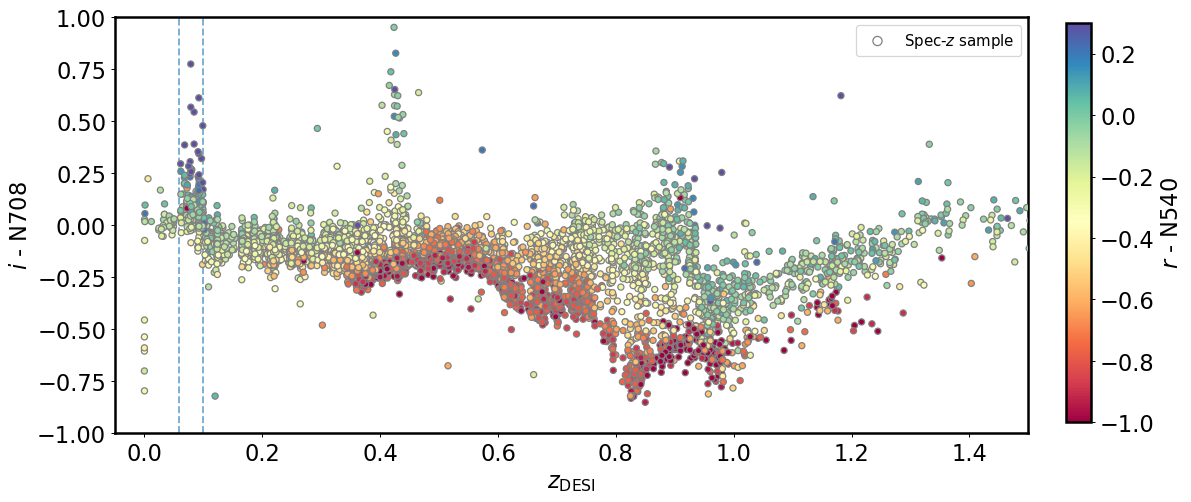

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

plt.sca(axes)
sct = plt.scatter(cat['z_desi'], cat['mag_i'] - cat['mag_N708'],
                  c=cat['mag_r'] - cat['mag_N540'],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, s=24,
                  edgecolors='gray', zorder=30, label='Spec-$z$ sample')

plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-1, 1.0)
plt.xlim(-0.05, 1.5)
plt.xlabel('$z_\mathrm{DESI}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(loc='upper right', fontsize=12, scatterpoints=1, frameon=True, markerscale=1.5)
leg.legendHandles[0].set_facecolor('none')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540')
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)

**We can ask students to explain why they see two spikes, one at z=0.05-0.10, and the other one at about z=0.45. Then ask them how to break this degeneracy (i.e., by introducing N540).**

In [73]:
cat_inband = cat[(z_spec < 0.11) & (z_spec > 0.05) & (cat['mag_i'] < 21.5)]
cat_inband['ssfr_1p0'] = cat_inband['sfr_1p0'] - cat_inband['mass_1p0']

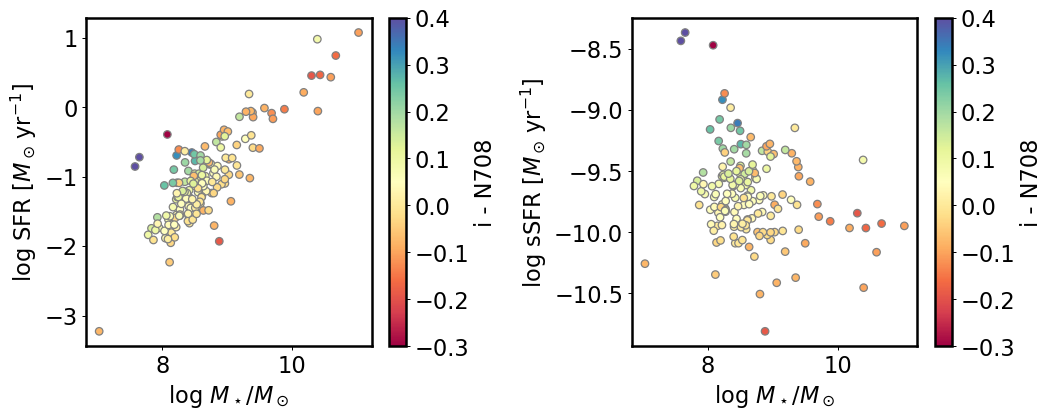

In [74]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax1)
plt.scatter(cat_inband['mass_1p0'], cat_inband['sfr_1p0'],
            c=cat_inband['mag_i'] - cat_inband['mag_N708'],
            ec='gray', cmap='Spectral', vmin=-0.3, vmax=0.4)
plt.colorbar(label='i - N708')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel(r'$\log\,\mathrm{SFR}\ [M_\odot\,\mathrm{yr}^{-1}]$')

plt.sca(ax2)
plt.scatter(cat_inband['mass_1p0'], cat_inband['ssfr_1p0'],
            c=cat_inband['mag_i'] - cat_inband['mag_N708'],
            ec='gray', cmap='Spectral', vmin=-0.3, vmax=0.4)
plt.colorbar(label='i - N708')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel(r'$\log\,\mathrm{sSFR}\ [M_\odot\,\mathrm{yr}^{-1}]$')

plt.tight_layout()

### Is there any other catalog-level thing we can play with?

### Tested: Generate cutout. One galaxy takes 10 Mb of space (grizy+N708+N540, together with PSFs).

In [75]:
from utils import format_merian_name

In [76]:
cat_inband = cat[(z_spec < 0.11) & (z_spec > 0.05) & (cat['mag_i'] < 21.5)]
cat_inband['ssfr_1p0'] = cat_inband['sfr_1p0'] - cat_inband['mass_1p0']
cnames = [format_object_name(obj['ALPHA_J2000'], obj['DELTA_J2000']) for obj in cat_inband]
cat_inband['name'] = cnames

In [77]:
cat_inband.write('./merian/cosmos_Merian_DR1_specz_inband.fits', overwrite=True)

https://tigress-web.princeton.edu/~jiaxuanl/galary/#merian_final_proj.txt

---

## Part 2: Make pretty pictures!!

Lupton et al. (2004): https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract

In [78]:
from astropy.io import fits

In [79]:
merian = Table.read("./merian/merian_dr1_specz_inband_lowmass_allbands.csv")
cutout_dir = "./merian/cutouts/"

In [80]:
i = 1850
obj = merian[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
cname = obj['cname']

In [81]:
# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merim.fits"))[1].data

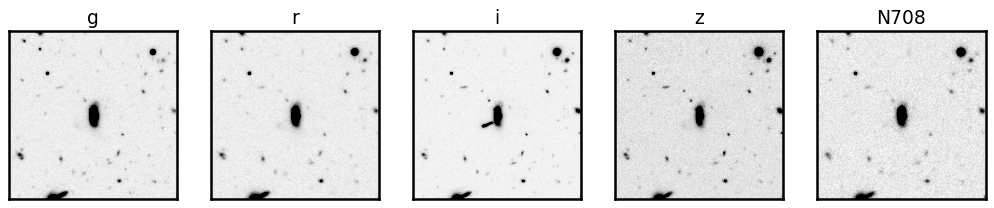

In [82]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys')
    axes[i].set_title(band, fontsize=15)

**Black & White images are boring... let's make them colorful**

In [83]:
from astropy.visualization import make_lupton_rgb
from ipywidgets import interact, FloatSlider

In [84]:
def update_rgb(stretch=1.0, Q=5.0):
    rgb = make_lupton_rgb(cutouts['i'], cutouts['r'], cutouts['g'], stretch=stretch, Q=Q)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, origin='lower')
    plt.axis('off')
    plt.title(f"stretch={stretch:.2f}, Q={Q:.2f}")
    plt.show()

# Add interactive sliders
interact(update_rgb,
         stretch=FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1, description='Stretch'),
         Q=FloatSlider(value=5.0, min=0.1, max=10.0, step=0.1, description='Q'));

interactive(children=(FloatSlider(value=0.5, description='Stretch', max=2.0, min=0.1), FloatSlider(value=5.0, …

Can you try combinations of other bands to make the image prettier?

### Part 2.1: Sersic fitting

- We can make them do their own Source Extractor: define threshold, then do detection, and generate a segmantation map
- Then we use `statmorph` to do the Sersic fit + other non-par measurement

In [85]:
from astropy.modeling import models, fitting

In [86]:
from utils import get_img_central_region

In [87]:
# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merim.fits"))[1].data

cutout_headers = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merpsf.fits"))[0].data

In [88]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# show_image(img, ax=axes[0], fig=fig, vmin=0, vmax=np.percentile(img, 95), title=f'{band} img')
# show_image(best_fit(x, y), ax=axes[1], fig=fig, vmin=0, vmax=np.percentile(img, 95), title='best-fit Sersic')
# show_image(img - best_fit(x, y), ax=axes[2], fig=fig, vmin=0, vmax=np.percentile(img, 95), title='residual')

In [90]:
import statmorph
from photutils.segmentation import detect_threshold, detect_sources
from astropy.convolution import convolve_fft

In [91]:
imgs = get_img_central_region(cutouts, 150)
img = imgs['N708']
psf = psfs['N708']

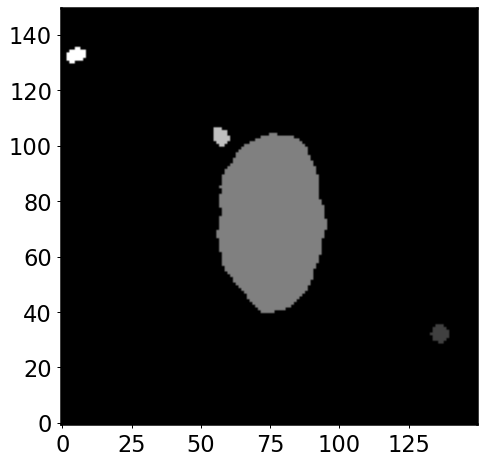

In [92]:
threshold = detect_threshold(img, 1.5)
npixels = 5  # minimum number of connected pixels
convolved_image = convolve_fft(img, psf)
segmap = detect_sources(convolved_image, threshold, npixels)
plt.imshow(segmap, origin='lower', cmap='gray')

ind = segmap.data[img.shape[1]//2, img.shape[0]//2]
segmap.keep_label(ind)

In [93]:
import sep
bkg = sep.Background(np.array(img).byteswap().newbyteorder())
rms = bkg.rms()

In [94]:
source_morphs = statmorph.source_morphology(
    img, segmap, weightmap=rms, psf=psf)
morph = source_morphs[0]

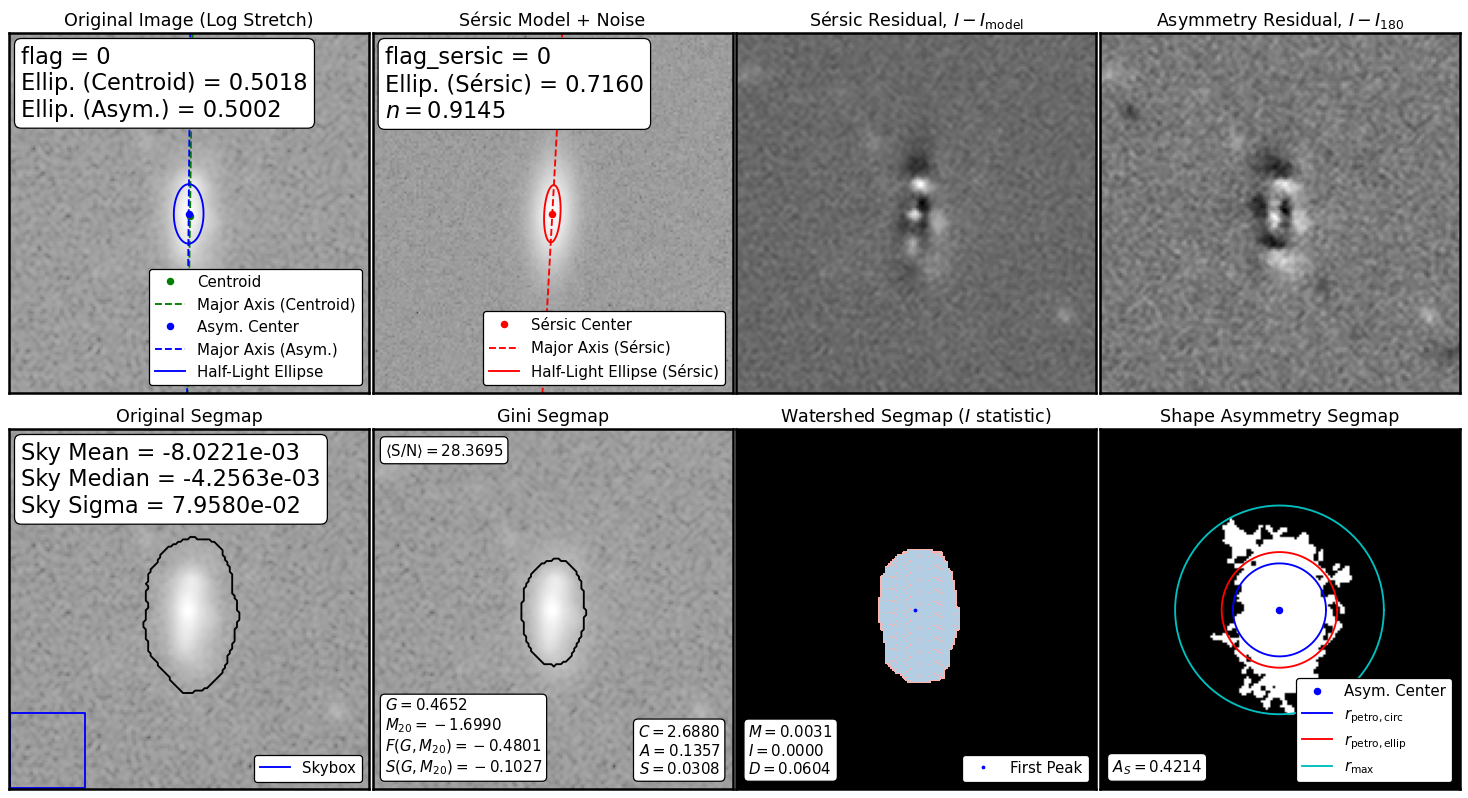

In [95]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [96]:
morph.sersic_n, morph.sersic_rhalf

(0.9144901579159838, 11.95859781025641)